0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

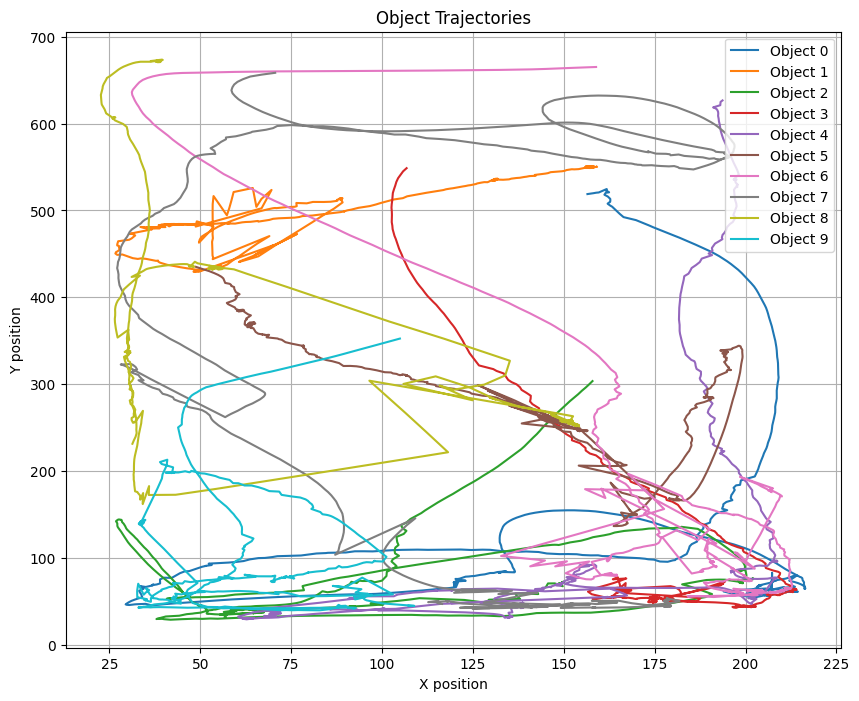

In [ ]:
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment  # For Hungarian algorithm
import imageio
import skimage
from skimage import color, io, filters
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import trackpy as tp
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

ds = 0.015
dt = 1/60
theory_max_velocity = 5 # 5cm/s top speed, expected under 3cm/s
theory_max_velocity_std = theory_max_velocity / 3 # 3sigma = Vmax
process_noise_std = theory_max_velocity_std/ds 

class KalmanFilter:
    def __init__(self):
        self.state = np.zeros(5)  # [x, y, vx, vy, area]
       
        self.F = np.array([
            [1, 0, dt, 0, 0],
            [0, 1, 0, dt, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])
        
        self.Q = process_noise_std**2 * np.eye(5)
        
        self.H = np.array([
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1]
        ])
        
        # Measurement noise covariance (controls measurement noise)
        self.R = np.eye(3) * 1e6
        
        # State covariance matrix
        self.P = np.eye(5) * 1e6

    def dynamic_measurement_noise(self, displacement):
        #print(displacement)
        """ Dynamically adjust measurement noise based on displacement (sensor reading difference). """
        if displacement < 1.11:  # Displacement less than 1 cm (in pixels/frame)
            return np.eye(3) * 0.01  # Very low measurement noise
        elif displacement <= 5:  # Displacement between 1 and 10 cm
            noise_value = 10 ** (displacement - 3.11)  # Quadratic increase
            return np.eye(3) * noise_value
        else:
            return np.eye(3) * 1e6  # Very high measurement noise (effectively discard measurement)

    def predict(self):
        self.state = self.F.dot(self.state)
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q
        
    def update(self, measurement):
        # Calculate displacement: Euclidean distance between current measurement and previous estimate
        prev_estimate = self.state[:2]  # Previous estimate (x, y)
        current_measurement = np.array(measurement[:2])  # Current measurement (x, y)
        
        displacement = np.linalg.norm(current_measurement - prev_estimate)

        # Update the measurement noise based on displacement
        self.R = self.dynamic_measurement_noise(displacement)
        
        # Kalman gain
        S = self.H.dot(self.P).dot(self.H.T) + self.R
        K = self.P.dot(self.H.T).dot(np.linalg.inv(S))
        
        # Measurement residual
        z = np.array(measurement)  # Measurement [x, y, area]
        y = z - self.H.dot(self.state)
        
        # Update state and covariance
        self.state = self.state + K.dot(y)
        self.P = (np.eye(len(self.P)) - K.dot(self.H)).dot(self.P)


class MHTTracker:
    def __init__(self, num_objects=10, max_hypotheses=4, collapse_threshold=150):
        self.num_objects = num_objects
        self.max_hypotheses = max_hypotheses
        self.collapse_threshold = collapse_threshold
        self.hypotheses = [{}]
        self.frame_count = 0
        self.trajectories = {i: [] for i in range(num_objects)}  # Store trajectories
        self.reading = {i: [] for i in range(num_objects)}
        # Initialize Kalman filters for each object, 3sigma = 2cm/s -> 0.015cm/pixel
        self.filters = [KalmanFilter() for _ in range(num_objects)]
        self.initialized = False  # Flag to check if filters are initialized

    def initialize_filters(self, detections):
        for i, detection in enumerate(detections):
            if i < self.num_objects:
                self.filters[i].state[0:2] = detection[0:2]  # Initialize position [x, y]
                self.filters[i].state[2:4] = np.zeros(2)     # Initialize velocity [vx, vy] to zero
                self.filters[i].state[4] = detection[2]      # Initialize area
        self.initialized = True  # Mark filters as initialized

    def predict(self):
        for f in self.filters:
            f.predict()

    def associate_detections(self, detections):
        cost_matrix = np.zeros((self.num_objects, len(detections)))
        
        for i, kalman_filter in enumerate(self.filters):
            predicted_state = kalman_filter.state
            for j, detection in enumerate(detections):
                predicted_pos = predicted_state[0:2]
                detection_pos = detection[0:2]
                distance = np.linalg.norm(predicted_pos - detection_pos) * ds / dt
                if distance < 3: cost_matrix[i, j] = distance
                else: cost_matrix[i, j] = distance**2

        # Use the Hungarian algorithm to find the best matches
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        return row_ind, col_ind

    def generate_hypotheses(self, detections):
        new_hypotheses = []
        if not self.initialized:
            self.initialize_filters(detections)
            return  # Skip hypothesis generation on the first frame

        row_ind, col_ind = self.associate_detections(detections)
        
        # Update Kalman filters based on associations
        for i, filter_idx in enumerate(row_ind):
            detection_idx = col_ind[i]
            detection = detections[detection_idx]
            self.filters[filter_idx].update(detection)
            # Save position for trajectory visualization
            self.trajectories[filter_idx].append(self.filters[filter_idx].state[0:2])
            self.reading[filter_idx].append(detection)

        # Store the hypothesis after updating
        current_hypothesis = {i: f.state for i, f in enumerate(self.filters)}
        new_hypotheses.append(current_hypothesis)
        self.hypotheses = new_hypotheses[:self.max_hypotheses]

    def resolve_hypotheses(self):
        if self.frame_count >= self.collapse_threshold:
            best_hypothesis = max(self.hypotheses, key=self.evaluate_hypothesis)
            self.hypotheses = [best_hypothesis]
            self.frame_count = 0  # Reset frame count after collapse
    
    #entropy
    def evaluate_hypothesis(self, hypothesis):
        variances = []
        for obj_id, state in hypothesis.items():
            trajectory = np.array(self.trajectories[obj_id])
            
            if len(trajectory) > 1:
                pos_diffs = np.diff(trajectory, axis=0)
                variance = np.var(pos_diffs, axis=0).sum()
                variances.append(variance)

        total_entropy = sum(variances)
        return 1 / (total_entropy + 1e-6)
    
    def track(self, detections):
        self.predict()
        self.generate_hypotheses(detections)
        self.resolve_hypotheses()
        self.frame_count += 1
        return self.hypotheses[0]

    def plot_trajectories(self):
        plt.figure(figsize=(10, 8))
        for obj_id, trajectory in self.trajectories.items():
            trajectory = np.array(trajectory)
            if len(trajectory) > 0:
                plt.plot(trajectory[40:, 0], trajectory[40:, 1], label=f'Object {obj_id}')
        
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Object Trajectories')
        plt.legend()
        plt.grid(True)
        plt.show()
        return self.trajectories, self.reading

# Load CSV file
df = pd.read_csv('c:/Users/marko/Desktop//Petka rok/k1mM_S4_2024-04-24 12-47-05/detections_0.csv')

# Example usage:
num_objects = 10  # Assume 10 objects to track
tracker = MHTTracker(num_objects)

# Process each frame and track objects
for frame in df['frame'].unique():
    print(frame)
    #if frame < 40: continue
    # Filter detections for the current frame
    detections = df[df['frame'] == frame][['x', 'y', 'area']].to_numpy()
    most_probable_hypothesis = tracker.track(detections)
    
    # Print the output for the current frame
    #print(f"Frame {frame}: {most_probable_hypothesis}")
    if frame > 800: break
# After tracking, plot the trajectories
tr, rd = tracker.plot_trajectories()



In [106]:
rd

{0: [array([122.20661157, 562.88429752, 242.        ]),
  array([126.40174672, 558.23144105, 229.        ]),
  array([129.83482143, 555.02232143, 224.        ]),
  array([134.24782609, 550.74347826, 230.        ]),
  array([136.37860082, 546.51851852, 243.        ]),
  array([139.30222222, 543.22222222, 225.        ]),
  array([142.024, 541.172, 250.   ]),
  array([143.80147059, 539.04044118, 272.        ]),
  array([146.20578778, 537.57877814, 311.        ]),
  array([145.9632107 , 537.98996656, 299.        ]),
  array([145.91891892, 538.21959459, 296.        ]),
  array([147.02866242, 537.62420382, 314.        ]),
  array([147.00668896, 537.44481605, 299.        ]),
  array([147.45833333, 537.00694444, 288.        ]),
  array([147.45833333, 537.00694444, 288.        ]),
  array([148.78625954, 534.89694656, 262.        ]),
  array([150.78113208, 533.81132075, 265.        ]),
  array([152.69395018, 532.56227758, 281.        ]),
  array([155.10588235, 530.76862745, 255.        ]),
  arr

In [105]:
k = 5
times = range(len(tr[k]))
x_preds = [pos[0] for pos in tr[k]]
y_preds = [pos[1] for pos in tr[k]]
x_rd = [pos[0] for pos in rd[k]]
y_rd = [pos[1] for pos in rd[k]]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot x-coordinate over time
ax1.plot(times, x_preds, label='Predicted x', color='blue', marker='.')
ax1.scatter(times, x_rd, label='Observed x', color='orange', alpha=0.6)
ax1.set_ylabel('X Coordinate')
ax1.legend()
ax1.grid(True)

# Plot y-coordinate over time
ax2.plot(times, y_preds, label='Predicted y', color='blue', marker='.')
ax2.scatter(times, y_rd, label='Observed y', color='orange', alpha=0.6)
ax2.set_xlabel('Time (Frame)')
ax2.set_ylabel('Y Coordinate')
ax2.legend()
ax2.grid(True)

plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

Frame 1799: 10 trajectories present.


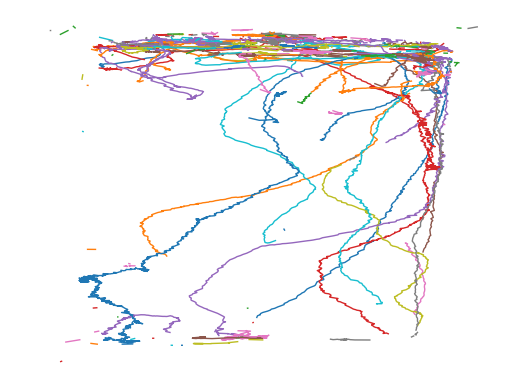

                x           y   area  eccentricity  frame  particle
0      122.439863  620.116838  291.0      0.881263      0         0
1       74.458874  489.588745  231.0      0.789096      0         1
2      132.098361  653.672131   61.0      0.648424      0         2
3      192.485207  654.840237  169.0      0.894854      0         3
4       76.181250  652.000000  160.0      0.872686      0         4
...           ...         ...    ...           ...    ...       ...
17929  199.175676  159.506757  296.0      0.766993   1799       781
17930  208.812121   99.284848  165.0      0.772557   1799       746
17931  154.133047   56.171674  233.0      0.869629   1799       516
17932  116.918103   35.146552  232.0      0.639211   1799       748
17934  129.875000   13.410714   56.0      0.852255   1799       799

[17935 rows x 6 columns]


In [50]:
search_range = 10
memory = 30
df = pd.read_csv('Test/detection/detections_0.csv')
tr = tp.link_df(df, search_range=search_range, memory=memory)

tp.plot_traj(tr, ax=plt.gca())
plt.axis('off')

plt.show()

print(tr)

In [51]:
tr2 = tr.copy()

In [66]:
tr = tr2.copy()
particles_with_more_than_30_frames = tr['particle'].value_counts()[tr['particle'].value_counts() > 400].index

# Filter the dataframe to only include those particles
tr = tr[tr['particle'].isin(particles_with_more_than_30_frames)]



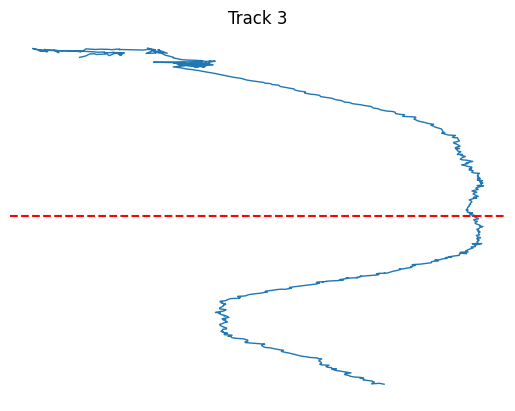

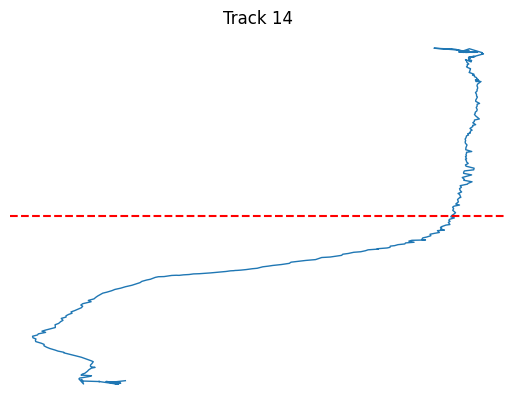

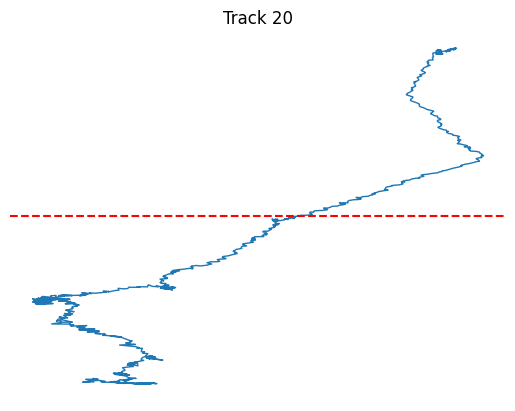

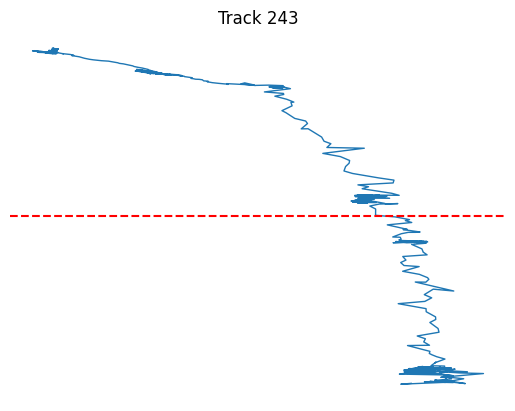

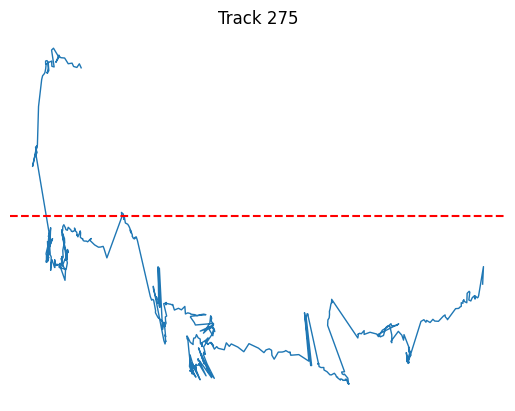

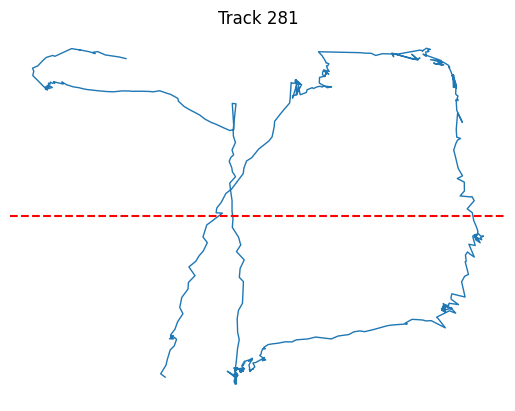

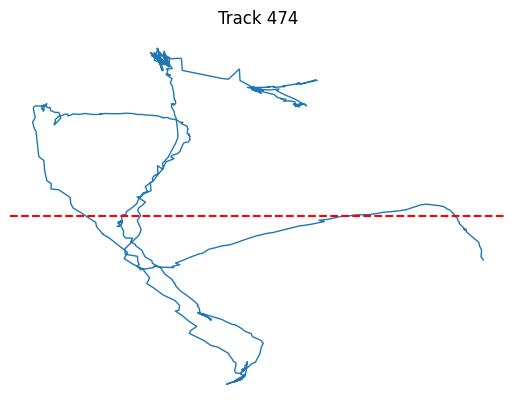

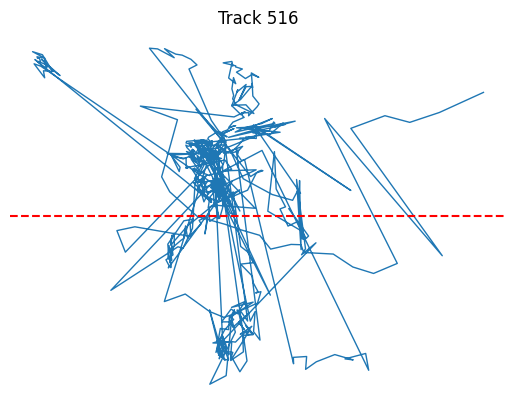

In [67]:
import matplotlib.pyplot as plt

# Assuming 'particle' is the column indicating track IDs
for obj_id, track in tr.groupby('particle'):
    plt.figure()  # Create a new figure for each track
    
    # Plot the trajectory for this particular object
    tp.plot_traj(track, ax=plt.gca())
    plt.title(f"Track {obj_id}")
    
    # Optional: Add a horizontal line through the middle of the y-values
    y_line = (track['y'].max() + track['y'].min()) / 2
    plt.axhline(y=y_line, color='red', linestyle='--')
    
    plt.axis('off')  # Turn off axis for cleaner visualization
    plt.show()  # Display the plot for the current track
